In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from inspect import signature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.metrics import precision_recall_curve, average_precision_score

from data_loading import load_data_and_counts, load_mibig_metadata

We are going to classify the following traits (dataset is in parenthesis)

- Gram + vs Gram - __(mibig)__
- antibiotic vs siderophore __(mibig)__
- antismash type (10 most relevant) __(antismash)__

using the following sets of features
- counts of cath transport hmms
- counts of pfam transport hmms

and see what appears.


## Loading MiBIG

In [4]:
mibig_metadata = load_mibig_metadata()

In [5]:
mibig_df = {}
mibig_counts = {}

In [6]:
x, u = load_data_and_counts('data/pfam/mibig_pfam25.tsv')
mibig_df['pfam'] = x
mibig_counts['pfam'] = u

x, u = load_data_and_counts('data/cathdb/mibig_cathdb.tsv')
mibig_df['cath'] = x
mibig_counts['cath'] = u

### Annoying

Our metadata includes way more BGCs than those that have transporters. Need to filter both by the overlap.

In [7]:
# Get overlapping BGCs
overlapping_bgcs = set(mibig_metadata.BGC).intersection(set(mibig_df['pfam'].BGC))
overlapping_bgcs = overlapping_bgcs.intersection(set(mibig_df['cath'].BGC))
overlapping_bgcs = list(overlapping_bgcs)

# Now apply to all datasets so observations match
mibig_metadata = mibig_metadata[mibig_metadata.BGC.isin(overlapping_bgcs)]

for k, df in mibig_df.items():
    idx = df.BGC.isin(overlapping_bgcs)
    mibig_df[k] = df[idx]
    mibig_counts[k] = mibig_counts[k][idx] # Count matrix doesn't have BGC column, so gotta hack

## Loading antiSMASH

In [8]:
antismash_metadata = pd.read_csv('data/metadata/antismash_metadata.tsv', sep='\t')

In [9]:
antismash_df = {}
antismash_counts = {}

In [10]:
x, u = load_data_and_counts('data/pfam/antismash_pfam25.tsv')
antismash_df['pfam'] = x
antismash_counts['pfam'] = u

x, u = load_data_and_counts('data/cathdb/antismash_cathdb.tsv')
antismash_df['cath'] = x
antismash_counts['cath'] = u

In [11]:
# Get overlapping BGCs
overlapping_bgcs = set(antismash_metadata.cluster).intersection(set(antismash_df['pfam'].BGC))
overlapping_bgcs = overlapping_bgcs.intersection(set(antismash_df['cath'].BGC))
overlapping_bgcs = list(overlapping_bgcs)

# Now apply to all datasets so observations match
antismash_metadata = antismash_metadata[antismash_metadata.cluster.isin(overlapping_bgcs)]

for k, df in antismash_df.items():
    idx = df.BGC.isin(overlapping_bgcs)
    antismash_df[k] = df[idx]
    antismash_counts[k] = antismash_counts[k][idx] # Count matrix doesn't have BGC column, so gotta hack

For our decision tree, we're going to fix some default hyperparameters. These can be modified.

In [36]:
def fit_tree_and_plot_results(X: pd.DataFrame,
                              y: pd.Series,
                              max_depth: int=2,
                              min_samples_split: int=3) -> tree.DecisionTreeClassifier:
    clf = tree.DecisionTreeClassifier(max_depth=max_depth,
                                  min_samples_split=min_samples_split)
    clf = clf.fit(X, y)
    preds = clf.predict_proba(X)
    
    # Plot PR Curve
    average_precision = average_precision_score(label, preds[:, 1])
    precision, recall, _ = precision_recall_curve(label, preds[:, 1])

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))
    
    # Plot the actual tree
    plt.figure(figsize=(15,15))
    tree.plot_tree(clf, feature_names=X.columns)
    plt.show()
    return clf, preds

# Gram + vs Gram - 

Using mibig_metadata to grab Gram positive vs Gram negative, let's see how well we can separate these with some simple decision trees. 

I believe 0 is gram - and 1 is gram +, so we will use only these two. Here is a plot of all values.

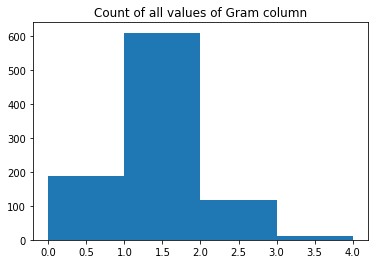

In [14]:
label = mibig_metadata.Gram
plt.hist(label, bins=[0,1,2,3,4])
plt.title('Count of all values of Gram column')

gram_idx = np.array(label.isin([0,1]))

label = label[gram_idx]

Results for Pfam


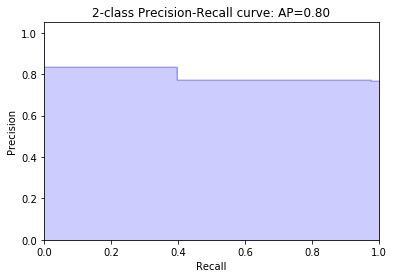

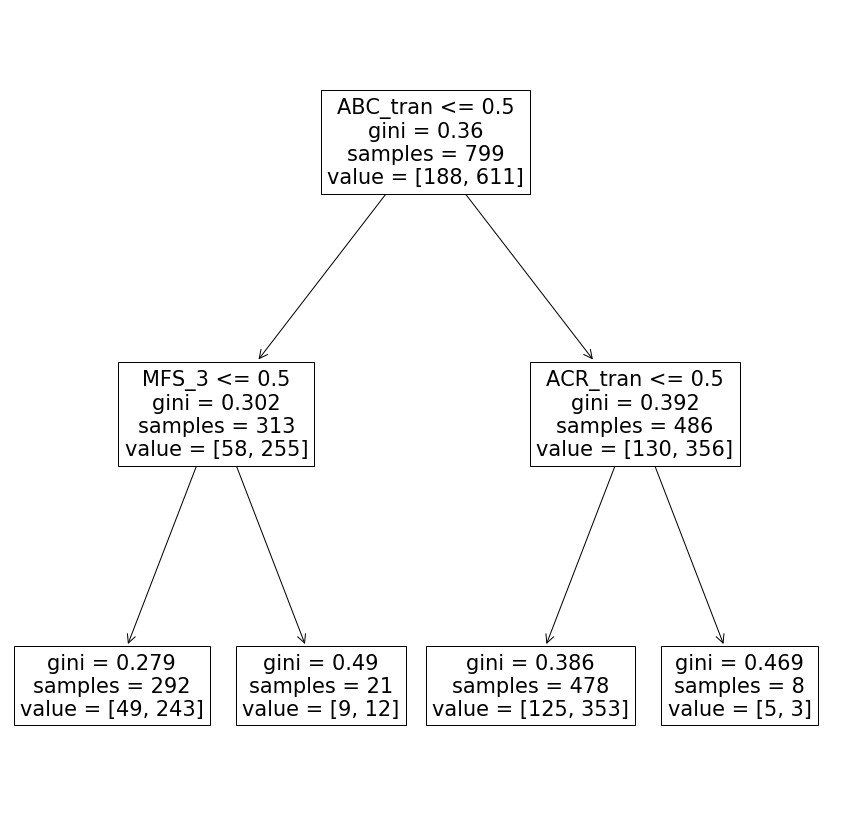

In [15]:
print('Results for Pfam')
_, _ = fit_tree_and_plot_results(mibig_counts['pfam'][gram_idx], label)

Results for CATH


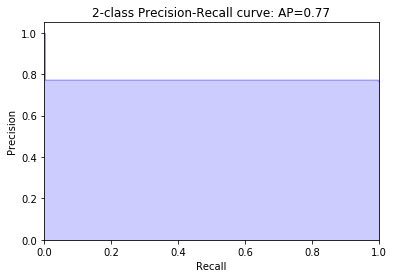

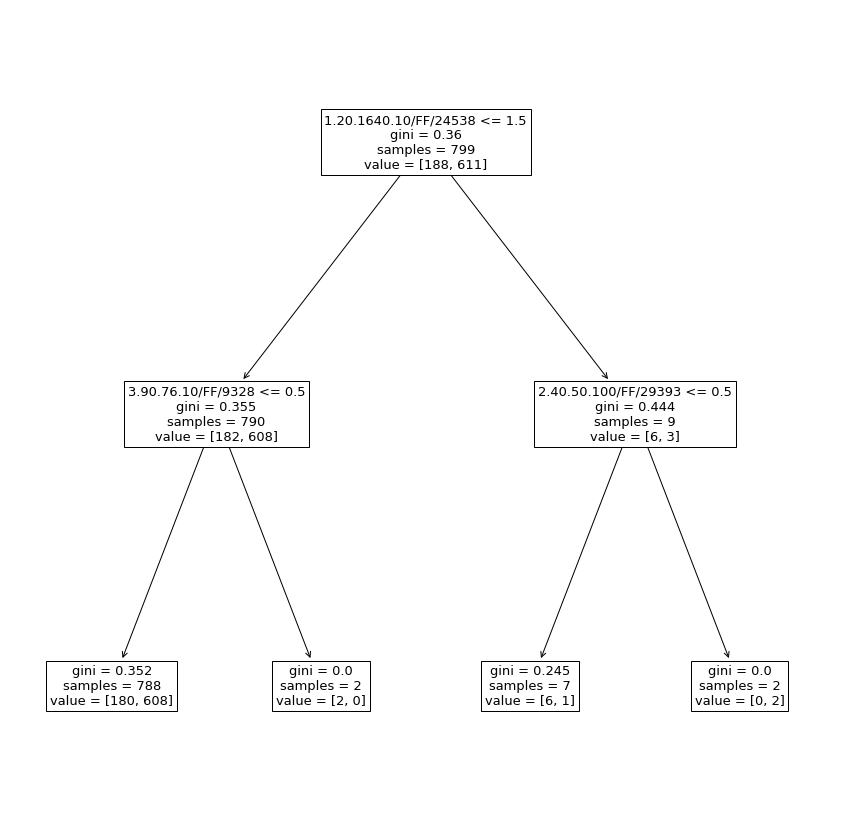

In [16]:
print('Results for CATH')
_, _ = fit_tree_and_plot_results(mibig_counts['cath'][gram_idx], label)

## Antibiotic vs Siderophore

Now we will compare antibiotic and siderophore in MIBiG

In [17]:
ab_sid_idx = (mibig_metadata.Siderophore == 1) | (mibig_metadata.Antibacterial == 1)
df = mibig_metadata[ab_sid_idx]

label = [-2]*len(df)
fuck = 0
for i, row in enumerate(df.iterrows()):
    if row[1]['Antibacterial'] == 1:
        if row[1]['Siderophore'] == 1:
            fuck += 1
        label[i] = 1
    elif row[1]['Siderophore'] == 1:
        label[i] = 0
    else:
        raise ValueError

(array([ 40., 159.]), array([0, 1, 2]), <a list of 2 Patch objects>)

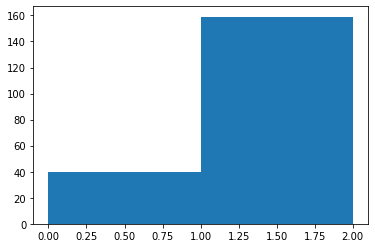

In [18]:
plt.hist(label, bins = [0,1,2])

Results for Pfam


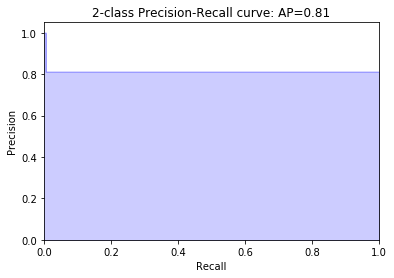

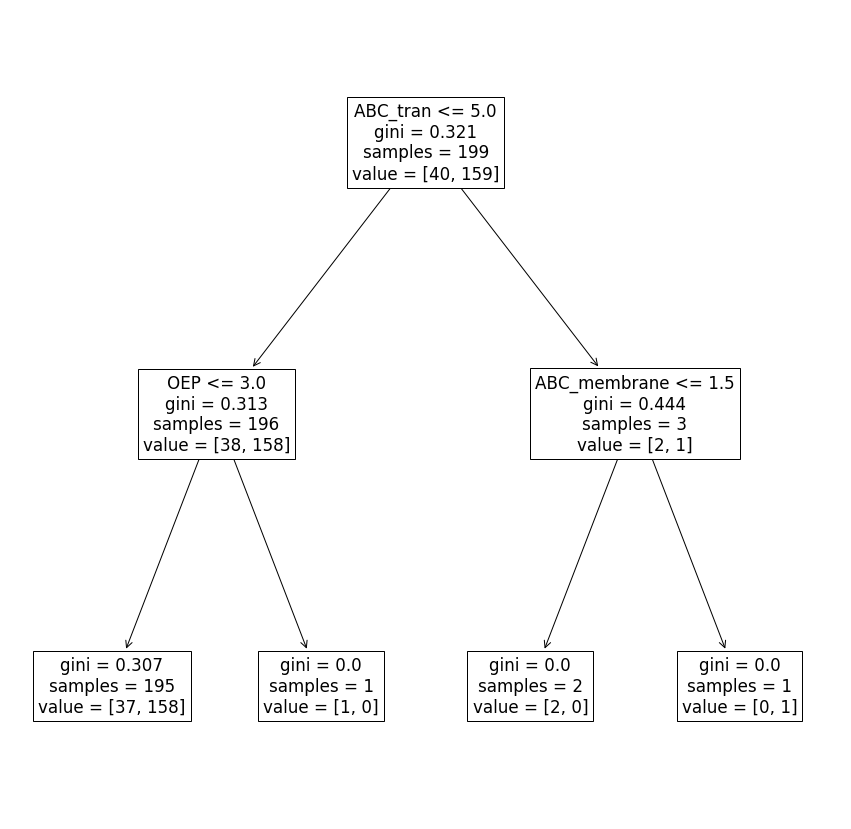

In [19]:
print('Results for Pfam')
X = mibig_counts['pfam']
X = X[mibig_df['pfam'].BGC.isin(df.BGC)]
_, _ = fit_tree_and_plot_results(X, label)

Results for CATH


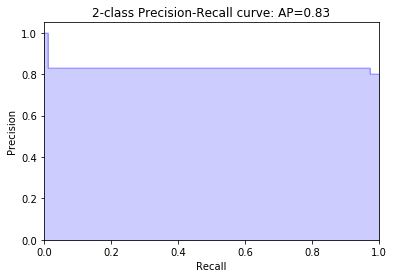

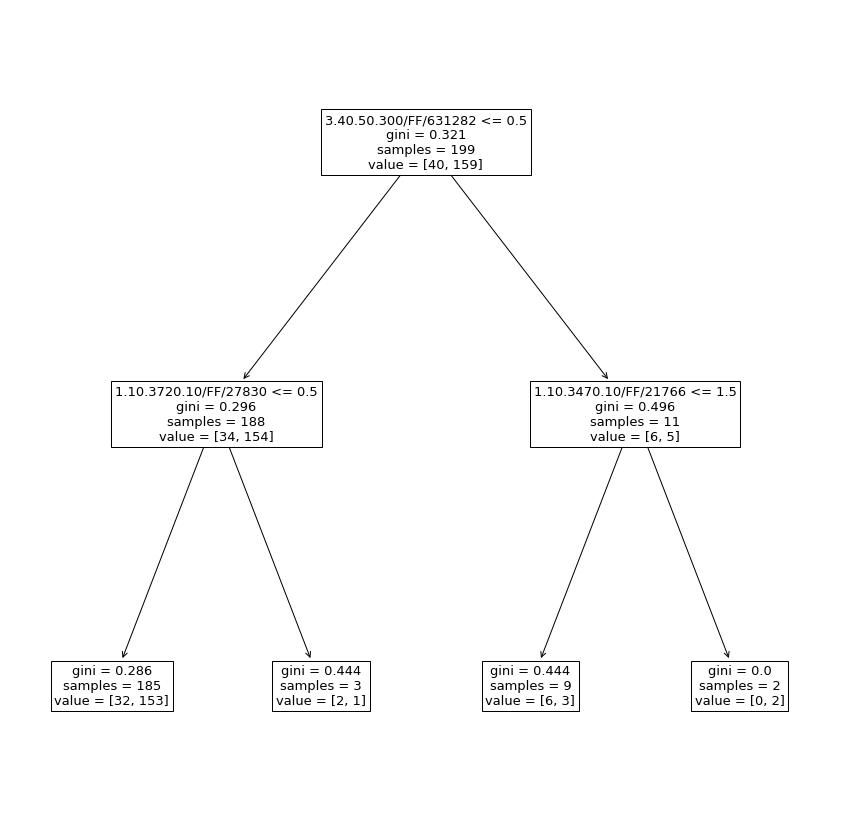

In [20]:
print('Results for CATH')
X = mibig_counts['cath']
X = X[mibig_df['cath'].BGC.isin(df.BGC)]
_, _ = fit_tree_and_plot_results(X, label)

## AntiSMASH Gram Prediction

Classes are actually pretty balanced here!

(array([38332.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 39442.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

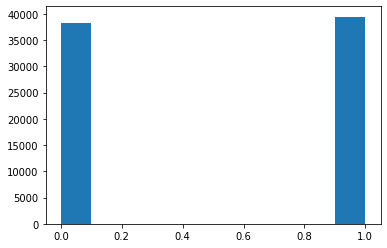

In [31]:
gram_antismash = antismash_metadata[antismash_metadata.gram.isin([0,1])]

label = gram_antismash.gram
plt.hist(label)

Results for Pfam


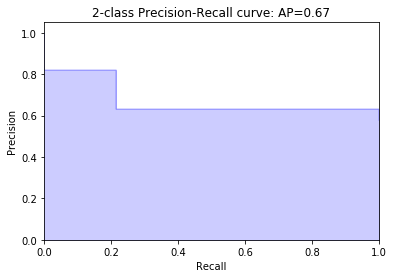

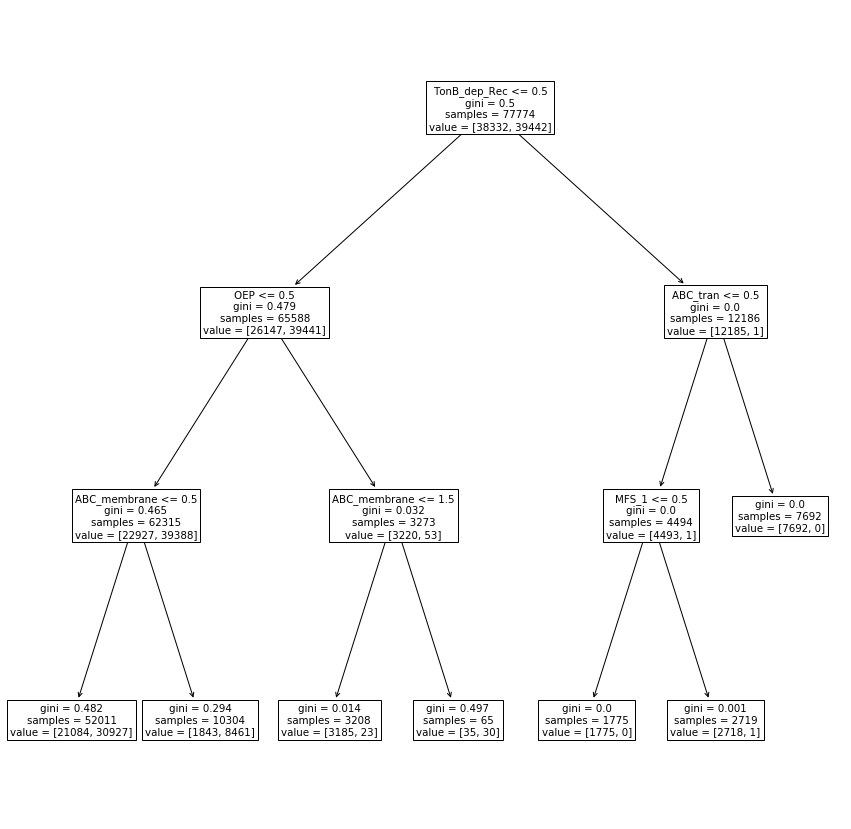

In [37]:
print('Results for Pfam')
X = antismash_counts['pfam']
X = X[antismash_df['pfam'].BGC.isin(gram_antismash.cluster)]
_, _ = fit_tree_and_plot_results(X, label, max_depth=3)

Results for CATH


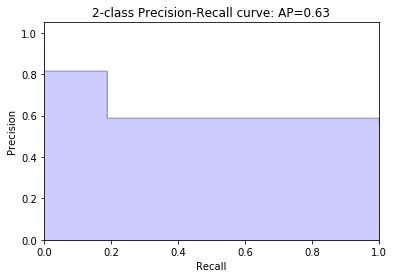

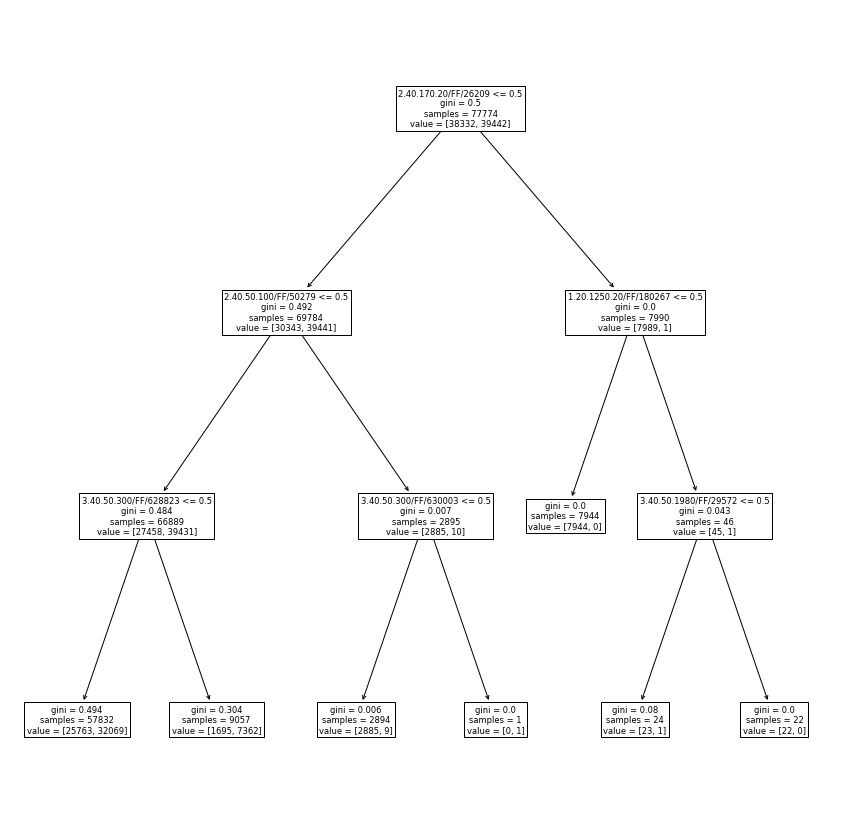

In [40]:
print('Results for CATH')
X = antismash_counts['cath']
X = X[antismash_df['cath'].BGC.isin(gram_antismash.cluster)]
_, _ = fit_tree_and_plot_results(X, label, max_depth=3)

## AntiSmash Type Prediction

In [24]:
from collections import Counter

In [25]:
type_counts = Counter(antismash_metadata.type)
type_counts.most_common(15)

[('nrps', 19528),
 ('bacteriocin', 7960),
 ('terpene', 7706),
 ('other', 6983),
 ('siderophore', 4304),
 ('t1pks-nrps', 3967),
 ('arylpolyene', 3675),
 ('t1pks', 3642),
 ('thiopeptide', 3420),
 ('lantipeptide', 3073),
 ('hserlactone', 2754),
 ('t3pks', 2503),
 ('lassopeptide', 1507),
 ('phosphonate', 861),
 ('t2pks', 838)]

Let's just start by distinguishing nrps and terpene. 

In [26]:
binary_antismash_meta = antismash_metadata[antismash_metadata.type.isin(['terpene', 'nrps'])]

label = binary_antismash_meta.type
label = [1 if i == 'nrps' else 0 for i in label]

Results for Pfam


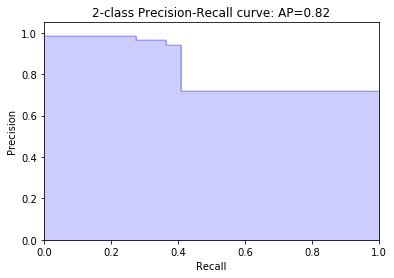

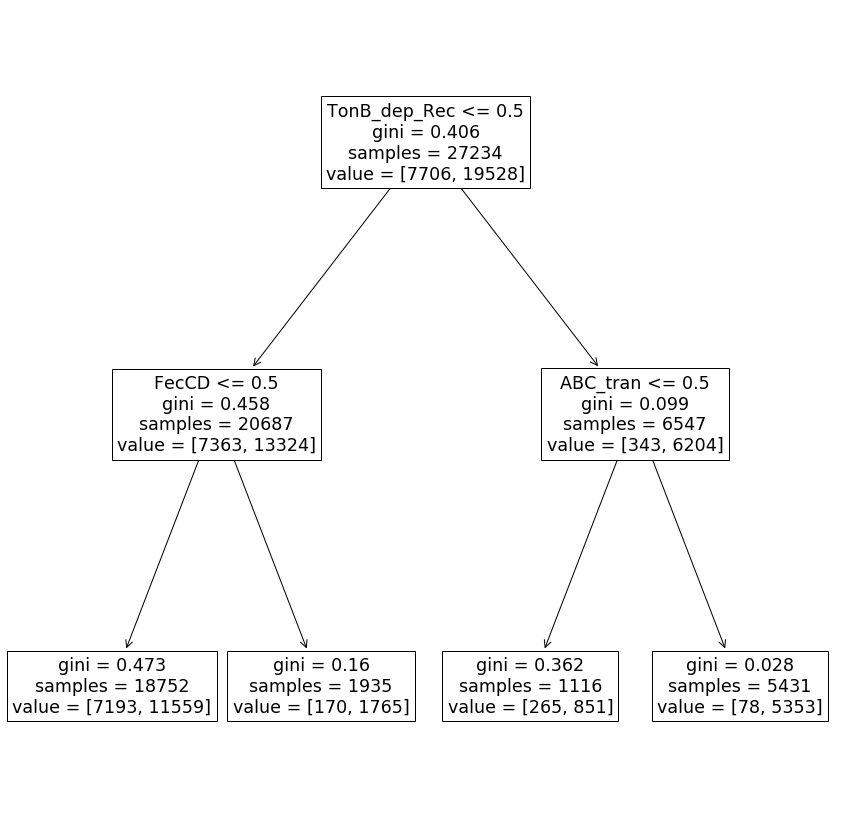

In [27]:
print('Results for Pfam')
X = antismash_counts['pfam']
X = X[antismash_df['pfam'].BGC.isin(binary_antismash_meta.cluster)]
_, _ = fit_tree_and_plot_results(X, label)

Results for CATH


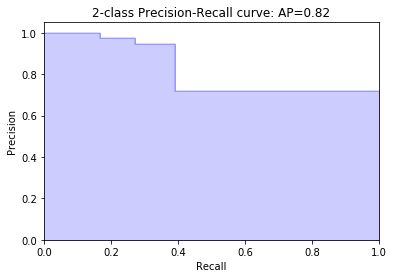

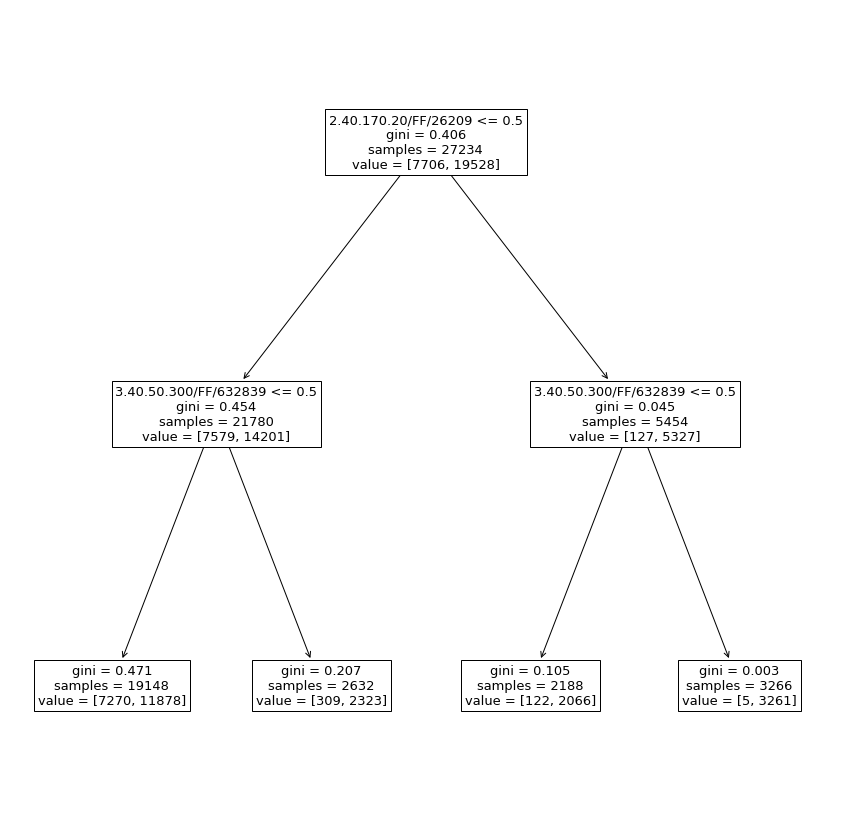

In [28]:
print('Results for CATH')
X = antismash_counts['cath']
X = X[antismash_df['cath'].BGC.isin(binary_antismash_meta.cluster)]
_, _ = fit_tree_and_plot_results(X, label)